In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None
# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from sisään_uloskäynnit import *

# tai from ... import *


# Jos datasetti on "df"

# Esim. find_outliers(df)
# Esim. draw_histogram(df['x'], df['y'], 20) <-- kolmas meinaa bins arvoa, eli histogrammin "rakeisuutta"

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData LIMIT 1000000;")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogram of x and y coordinates

x mean:  2007.42516
y mean:  524.458634
x std:  880.5673627763946
y std:  1056.1131432857248


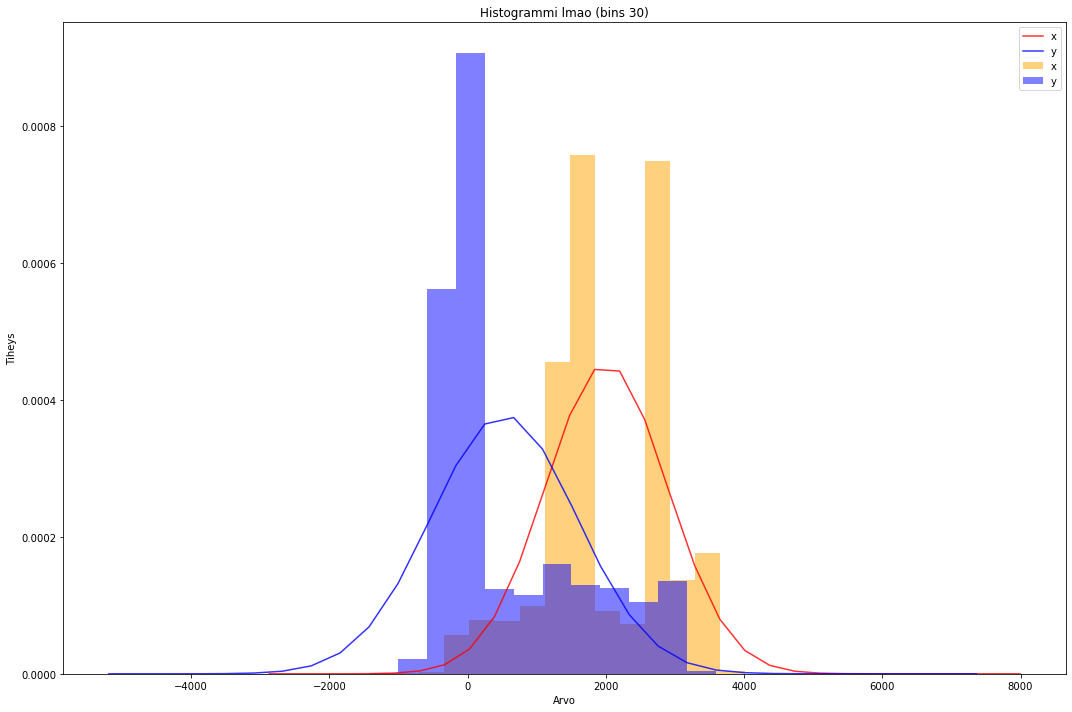

In [10]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 5161
uniques in y 5033
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 3
------------------------------
Outliers

Data with outliers:  1000000
Ouliers removed:     6483
Data after:  993517


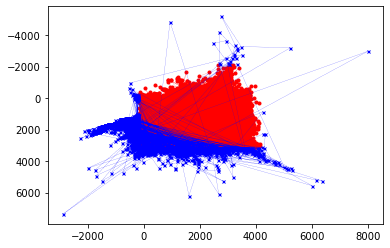

In [3]:
df1 = find_outliers(df, 'x', 'y')

### Merge if the "_merge" column has the value "both"

In [ ]:
df2 = df.drop_duplicates().merge(df1.drop_duplicates(), on=df1.columns.to_list(), 
                   how='left', indicator=True)
print(df2['_merge'].unique())
#df2.loc[df2._merge=='left_only',df2.columns!='_merge']
df2 = df2.loc[df2['_merge'] == 'both']
df = df2.drop(columns=['_merge'])
df

# Outliers using isolation forest

Dataframe lenght before: 993517
Dataframe lenght after: 794813
Total outliers detected: 198704


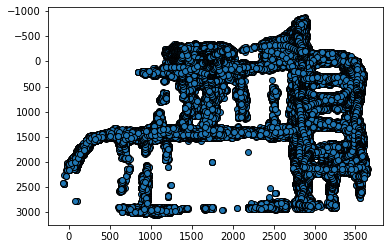

In [12]:
df1 = isolation_forest(df1, 800000, 0, .2)

# Cleaning Node_id, timestamp, q, z columns

In [4]:
df1 = clean_dataframe(df1)
df1.head(5)

,node_id,timestamp,x,y
0,1,2020-06-24 15:20:08.533,2762,-257
1,1,2020-06-24 15:20:08.620,2870,-344
2,1,2020-06-24 15:20:09.623,2916,-344
3,1,2020-06-24 15:20:09.623,2894,-254
4,1,2020-06-24 15:20:10.116,2888,-188
...,...,...,...,...
999995,3,2020-08-16 12:08:11.426,1938,-267
999996,3,2020-08-16 12:08:20.426,1922,-242
999997,3,2020-08-16 12:08:39.426,2002,-332
999998,3,2020-08-16 12:09:16.426,1961,-281


# Adding xy_grid values to dataframe (50x50)

In [5]:
df1 = xy_to_grid(df1, df1.x, df1.y, 50)
df1.head(5)

,node_id,timestamp,x,y,x_grid,y_grid,xy_grid
0,3,2020-06-26 19:04:51.645,-141,-369,0,16,1
1,2,2020-07-12 10:05:35.793,-192,-217,0,17,2
2,1,2020-10-01 15:20:04.062,-156,-171,0,18,3
3,2,2020-07-12 10:05:36.793,-140,-209,0,18,3
4,2,2020-07-12 10:05:44.793,-107,-178,0,18,3


# 

In [ ]:
start=datetime.now()

# Otetaan talteen alkuperäinen data vertailua varten
dftest = df1.copy()
table_alkuperäinen = len(df1['x'])

velocity.x_vel(df1)
velocity.y_vel(df1)
velocity.draw_vel(dftest, df1)

print("Aika: ",datetime.now()-start)
print(len(df1['x']))
print("Poistettuja pisteitä: ", table_alkuperäinen - len(df1['x']))

# Write cleaned and diskretized dataframe to mariadb database

In [ ]:
write_df_to_mariadb(df1)

# Find and draw entrance and exit

In [ ]:
sisään_xx, sisään_yy = sisään(df1)
ulos_xx, ulos_yy = ulos(df1)

draw_exits(df1, sisään_xx, sisään_yy, ulos_xx, ulos_yy)